In [30]:
# import
import numpy as np
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm
from sklearn.model_selection import train_test_split
import scipy.io
import utils.starplus_utils as starp
from numpy.linalg import norm
from tensor.utils import assert_compatile_sizes_modek, reshape, make_axis_iterable
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib.cm import ScalarMappable
import seaborn as sns
import pandas as pd

In [31]:
# ==================================================================================================================== #
# define projection
def projection(A, U, prod_type):
    if prod_type == 'm':
        training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type,M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
        return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
    else:
        training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type)
        return tp.ten_prod(U, training_coeff, prod_type=prod_type) 

In [32]:
# ==================================================================================================================== #
# for reproducibility
np.random.seed(20)

In [33]:
# load data
# we need the variables
#   training_data, training_labels, test_data, test_labels, num_classes
num_classes = 2
star_plus_data = scipy.io.loadmat('data-starplus-04847-v7.mat')
tensor_PS, labels = starp.get_labels(star_plus_data)
tensor_PS  = tensor_PS / norm(tensor_PS)

In [34]:
print(np.transpose(labels).shape)
print(np.moveaxis(tensor_PS, -1, 0).shape)
training_data, test_data, training_labels, test_labels = train_test_split(np.moveaxis(tensor_PS, -1, 0), np.transpose(labels), test_size=0.33, random_state=42)
print(training_data.shape)
(unique, counts) = np.unique(test_labels, return_counts=True)
print(unique)
print(counts)
(unique, counts) = np.unique(training_labels, return_counts=True)
print(unique)
print(counts)

(80, 1)
(80, 64, 64, 8, 16)
(53, 64, 64, 8, 16)
[0. 1.]
[14 13]
[0. 1.]
[26 27]


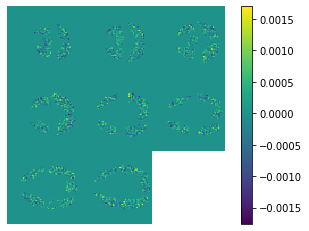

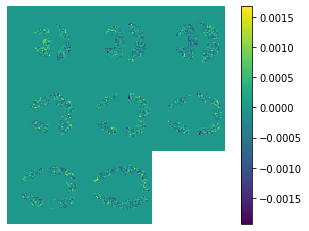

In [35]:
# visualize data
# use the existing tools or write your own!
plt.figure(1)
montage_array(training_data[0, :, :, :, 0], cmap='viridis')
plt.show()
plt.figure(2)
montage_array(test_data[0, :, :, :, 0], cmap='viridis')
plt.show()

In [36]:
# move the label number to second axis
training_data = np.moveaxis(training_data, 0, 1)
test_data = np.moveaxis(test_data, 0, 1)
print(training_data.shape)
print(test_data.shape)

(64, 53, 64, 8, 16)
(64, 27, 64, 8, 16)


In [37]:
# create the boolean array for training and testing
boolean_list = []
for i in (training_labels):
    boolean_list.append(i[0])
boolean_array_training = np.asarray(boolean_list)
print(boolean_array_training)

boolean_list = []
for i in (test_labels):
    boolean_list.append(i[0])
boolean_array_testing = np.asarray(boolean_list)
print(boolean_array_testing)

[1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1.]


In [38]:
# HaarMatrix utilized for m-product
def haarMatrix(n):
    # n is the power of 2
    if n > 2:
        M = haarMatrix(n / 2)
    else:
        return np.array([[1, 1], [1, -1]])
    M_n = np.kron(M, [1, 1])
    M_i = np.sqrt(n/2)*np.kron(np.eye(len(M)), [1, -1])
    M = np.vstack((M_n, M_i))
    return M
def haar_normalized(n):
    M = haarMatrix(n)
    M = M/np.sqrt(np.sum(M[0]))
    return M

0
train accuracy = 100.00
test accuracy = 62.96
train accuracy = 100.00
test accuracy = 66.67
train accuracy = 100.00
test accuracy = 74.07
train accuracy = 100.00
test accuracy = 59.26
[0.6296296296296297, 0.6666666666666666, 0.7407407407407407, 0.5925925925925926]
[0.6296296296296297, 0.6666666666666666, 0.7407407407407407, 0.5925925925925926]
   number_of_basis_element  testing_acc  training_acc Method
0                       16     0.629630           1.0      f
1                       17     0.666667           1.0      f
2                       18     0.740741           1.0      f
3                       19     0.592593           1.0      f
1
train accuracy = 100.00
test accuracy = 81.48
train accuracy = 100.00
test accuracy = 85.19
train accuracy = 100.00
test accuracy = 85.19
train accuracy = 100.00
test accuracy = 81.48
[0.8148148148148148, 0.8518518518518519, 0.8518518518518519, 0.8148148148148148]
   number_of_basis_element  testing_acc  training_acc Method
0                  

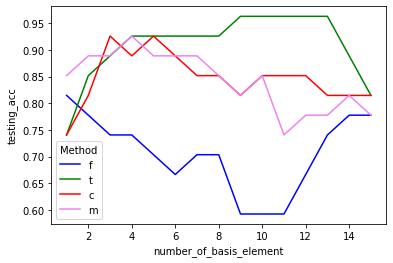

In [42]:
# ==================================================================================================================== #
# form local t-svd
# num_class should be 2
num_classes = len(np.unique(training_labels))

method_list_all = ['f','t','c','m']
global Merged_Dataset
global Merged_Dataset_1
global Merged_Dataset_2
global Merged_Dataset_3
global Merged_Dataset_4
global Merged_Dataset_5
global Merged_Dataset_6
global Merged_Dataset_7
for ii in range(len(method_list_all)):
    print(ii)
    prod_type = method_list_all[ii]
    training_acc_list = []
    testing_acc_list = []
    trail_list = []
    method_list = []
    for k in range(16,20):
        U = []
        for i in range(num_classes):
            if prod_type == 'm':
                u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
                U.append(u)
            else:
                u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k, prod_type=prod_type)
                U.append(u)
        # ==================================================================================================================== #
        # compute results on training and test data
        training_error = np.zeros([num_classes, training_data.shape[1]])
        test_error = np.zeros([num_classes, test_data.shape[1]])
        for i in range(num_classes):
            training_projection = projection(training_data, U[i], prod_type=prod_type)
            training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

            test_projection = projection(test_data, U[i], prod_type=prod_type)
            test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)

        # classification
        training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
        test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

        # results
        training_num_correct = np.sum(training_predicted_classes == boolean_array_training)
        training_accuracy = training_num_correct / training_data.shape[1]

        test_num_correct = np.sum(test_predicted_classes == boolean_array_testing)
        test_accuracy = test_num_correct / test_data.shape[1]

        print('train accuracy = %0.2f' % (100 * training_accuracy))
        print('test accuracy = %0.2f' % (100 * test_accuracy))
        training_acc_list.append(training_accuracy)
        testing_acc_list.append(test_accuracy)
        trail_list.append(k)
        method_list.append(method_list_all[ii])
    print(testing_acc_list)
    if ii == 0:
        print(testing_acc_list)
        Merged_Dataset = pd.DataFrame(
            {'number_of_basis_element': trail_list,
             'testing_acc': testing_acc_list,
             'training_acc':training_acc_list,
             'Method': method_list,
            })
        print(Merged_Dataset)
    elif ii == 1:
        Merged_Dataset_1 = pd.DataFrame(
            {'number_of_basis_element': trail_list,
             'testing_acc': testing_acc_list,
             'training_acc':training_acc_list,
             'Method': method_list,
            })
        Merged_Dataset_2 = Merged_Dataset.append(Merged_Dataset_1)
        print(Merged_Dataset_2)
    elif ii == 2:
        Merged_Dataset_3 = pd.DataFrame(
            {'number_of_basis_element': trail_list,
             'testing_acc': testing_acc_list,
             'training_acc':training_acc_list,
             'Method': method_list,
            })
        Merged_Dataset_4 = Merged_Dataset_2.append(Merged_Dataset_3)
    elif ii == 3:
        Merged_Dataset_5 = pd.DataFrame(
            {'number_of_basis_element': trail_list,
             'testing_acc': testing_acc_list,
             'training_acc':training_acc_list,
             'Method': method_list,
            })
        Merged_Dataset_7 = Merged_Dataset_4.append(Merged_Dataset_5)
        print(Merged_Dataset_7)
        
ax = sns.lineplot(x="number_of_basis_element", y="testing_acc", hue = "Method", ci = 'sd', data= Merged_Dataset_6, palette=['blue','green','red','violet'], sizes=(10, 10), err_style = "band", markers=True)
# ax = sns.lineplot(x="trail_list", y="training_acc", hue = "Method", ci = 'sd', data= Merged_Dataset_6, palette=['blue','green','red','violet'], sizes=(10, 10), err_style = "band", markers=True)

In [40]:
print(Merged_Dataset_6)

    number_of_basis_element  testing_acc  training_acc Method
0                         1     0.814815           1.0      f
1                         2     0.777778           1.0      f
2                         3     0.740741           1.0      f
3                         4     0.740741           1.0      f
4                         5     0.703704           1.0      f
5                         6     0.666667           1.0      f
6                         7     0.703704           1.0      f
7                         8     0.703704           1.0      f
8                         9     0.592593           1.0      f
9                        10     0.592593           1.0      f
10                       11     0.592593           1.0      f
11                       12     0.666667           1.0      f
12                       13     0.740741           1.0      f
13                       14     0.777778           1.0      f
14                       15     0.777778           1.0      f
0       

In [43]:
Merged_Dataset_8 = Merged_Dataset_6.append(Merged_Dataset_7)
print(Merged_Dataset_8)

    number_of_basis_element  testing_acc  training_acc Method
0                         1     0.814815           1.0      f
1                         2     0.777778           1.0      f
2                         3     0.740741           1.0      f
3                         4     0.740741           1.0      f
4                         5     0.703704           1.0      f
..                      ...          ...           ...    ...
3                        19     0.666667           1.0      c
0                        16     0.703704           1.0      m
1                        17     0.740741           1.0      m
2                        18     0.703704           1.0      m
3                        19     0.703704           1.0      m

[76 rows x 4 columns]


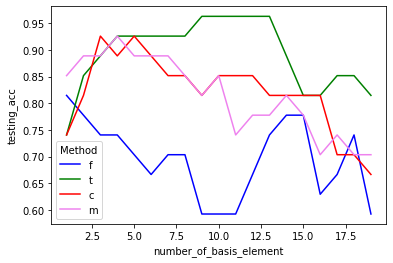

In [44]:
ax = sns.lineplot(x="number_of_basis_element", y="testing_acc", hue = "Method", ci = 'sd', data= Merged_Dataset_8, palette=['blue','green','red','violet'], sizes=(10, 10), err_style = "band", markers=True)